In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ignore warnings
warnings.filterwarnings('ignore')

# load the data
data = pd.read_excel('../../data/distillation_column.xlsx', sheet_name='Sheet1')
data.columns = ['t_in', 'p_in', 'e_cond', 'e_boiler', 'styr_flow']
data['specific_energy'] = (data['e_cond'] + data['e_boiler']) / data['styr_flow']
data.head()

,t_in,p_in,e_cond,e_boiler,styr_flow,specific_energy
0,303.15,20000.0,7128.94,8803.54,4.40306,3618.501678
1,303.15,22105.3,7128.94,8803.52,4.40306,3618.497136
2,303.15,24210.5,7128.94,8803.51,4.40306,3618.494865
3,303.15,26315.8,7128.94,8803.49,4.40306,3618.490323
4,303.15,28421.1,7128.94,8803.48,4.40306,3618.488051


In [2]:
# randomly select 5 % of rows indexs to be the temperature anomalies
anomalous_indices = np.random.choice(data.index, int(len(data) * 0.05), replace=False)
data.loc[anomalous_indices, 't_in'] += np.random.normal(100, 100, len(anomalous_indices))
data.head()

,t_in,p_in,e_cond,e_boiler,styr_flow,specific_energy
0,303.15,20000.0,7128.94,8803.54,4.40306,3618.501678
1,303.15,22105.3,7128.94,8803.52,4.40306,3618.497136
2,303.15,24210.5,7128.94,8803.51,4.40306,3618.494865
3,303.15,26315.8,7128.94,8803.49,4.40306,3618.490323
4,303.15,28421.1,7128.94,8803.48,4.40306,3618.488051


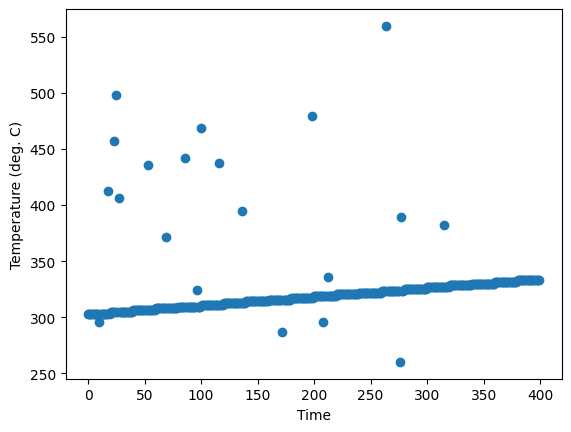

In [3]:
# plot the temperature anomalies
plt.scatter(data.index, data['t_in'])
plt.xlabel('Time')
plt.ylabel('Temperature (deg. C)')
plt.show()

In [4]:
# load the specific energy model
model = joblib.load('../models/specific_energy_model.pkl')

# predict the specific energy
data['specific_energy'] = model.predict(data[['t_in']])
data.head()

,t_in,p_in,e_cond,e_boiler,styr_flow,specific_energy
0,303.15,20000.0,7128.94,8803.54,4.40306,3618.900468
1,303.15,22105.3,7128.94,8803.52,4.40306,3618.900468
2,303.15,24210.5,7128.94,8803.51,4.40306,3618.900468
3,303.15,26315.8,7128.94,8803.49,4.40306,3618.900468
4,303.15,28421.1,7128.94,8803.48,4.40306,3618.900468


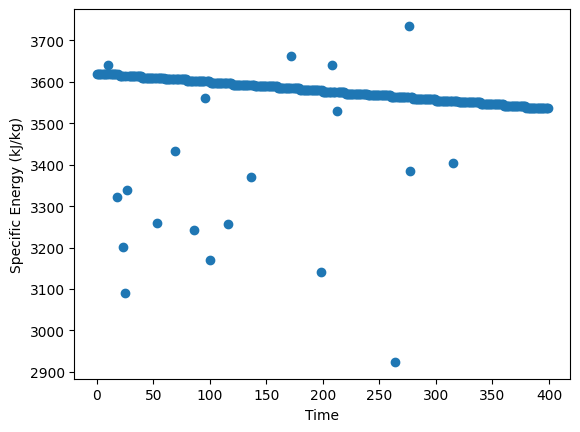

In [5]:
# plot the specific energy
plt.scatter(data.index, data['specific_energy'])
plt.xlabel('Time')
plt.ylabel('Specific Energy (kJ/kg)')
plt.show()

In [6]:
# tag the anomalous data
data['anomaly'] = np.where(data.index.isin(anomalous_indices), 1, 0)
data.head()

,t_in,p_in,e_cond,e_boiler,styr_flow,specific_energy,anomaly
0,303.15,20000.0,7128.94,8803.54,4.40306,3618.900468,0
1,303.15,22105.3,7128.94,8803.52,4.40306,3618.900468,0
2,303.15,24210.5,7128.94,8803.51,4.40306,3618.900468,0
3,303.15,26315.8,7128.94,8803.49,4.40306,3618.900468,0
4,303.15,28421.1,7128.94,8803.48,4.40306,3618.900468,0


In [7]:
# sample x and y
x = data[['t_in', 'specific_energy']]
y = data['anomaly']

In [8]:
# scale the features and fit SOM
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x)

x_sc = scaler.transform(x)

# determine the grid size
N = int(np.sqrt(5 * np.sqrt(x_sc.shape[0]))) 
print(f'Map Size: {N}')

Map Size: 10


In [9]:
# fit a SOM with the best influence radius (n=1)
N = 5
som = MiniSom(x=N, y=N, input_len=x_sc.shape[1], sigma=1, learning_rate=0.5)
som.random_weights_init(x_sc)
som.train_random(x_sc, num_iteration=200)

In [10]:
# get the distance map
dists = som.distance_map()

In [11]:
# get winning neurons for each sample
dist_list = []
winning = []
for i in range(x_sc.shape[0]):

    # get winning neuron coordinates
    coord = som.winner(x=x_sc[i])
    winning.append(coord)

    # get distance
    dist_list.append(dists[coord])

# add the winning neurons to the data
x_data = pd.DataFrame(scaler.inverse_transform(x_sc), columns=['t_in', 'specific_energy'])
x_data['winning'] = winning
x_data['dist'] = dist_list

# append the target column
x_data['anomaly'] = y

In [12]:
x_data

,t_in,specific_energy,winning,dist,anomaly
0,303.15,3618.900468,"(1, 4)",0.035903,0
1,303.15,3618.900468,"(1, 4)",0.035903,0
2,303.15,3618.900468,"(1, 4)",0.035903,0
3,303.15,3618.900468,"(1, 4)",0.035903,0
4,303.15,3618.900468,"(1, 4)",0.035903,0
...,...,...,...,...,...
395,333.15,3537.580343,"(3, 2)",0.518035,0
396,333.15,3537.580343,"(3, 2)",0.518035,0
397,333.15,3537.580343,"(3, 2)",0.518035,0
398,333.15,3537.580343,"(3, 2)",0.518035,0


In [13]:
# check probability of being an anomaly based the winning neuron
prob_table = x_data.groupby('winning')['anomaly'].agg(func=['mean', 'count'])

# save prob_table as a JSON
prob_table.to_json('../../data/prob_table.json')


In [14]:
# save the data
data.to_csv('../../data/data_with_anomaly.csv', index=False)

In [15]:
# save the SOM
joblib.dump(som, '../models/som.pkl')

['../models/som.pkl']

In [16]:
# save the scaler
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']